In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

cache_dir = "/users/thua5/.cache/unibench/outputs/"

In [4]:
def load_accuracy(text_model_size, vision_model_size, benchmark_name, use_peft=False):

    add_on_str = "peft" if use_peft else "projection_only" 

    if benchmark_name == "coco_validation":

        with open(f"/users/thua5/ssl_proj/eval_results/clip_{text_model_size}-text_{vision_model_size}-vision_{add_on_str}_seed44.json", "r") as f:
            results = json.load(f)

        # clip_large-text_large-vision_peft_seed44.json


        return results['average_accuracy']

    else:
        results = pd.read_feather(f"{cache_dir}clip_{text_model_size}_text_{vision_model_size}_vision_{add_on_str}_seed44/{benchmark_name}.f")

        return np.mean(results["correctness"])

In [5]:
def plot_side_by_side_heatmaps(dataset, cmap='RdYlBu', text_saliency_threshold=0.25):
    sizes = ["small", "medium", "large"]
    size_labels = ["S", "M", "L"]
    peft_heatmap = np.zeros((len(sizes), len(sizes)))
    non_peft_heatmap = np.zeros((len(sizes), len(sizes)))

    for i, vision_size in enumerate(sizes):
        for j, text_size in enumerate(sizes):
            peft_heatmap[i, j] = load_accuracy(text_size, vision_size, dataset, use_peft=True)
            non_peft_heatmap[i, j] = load_accuracy(text_size, vision_size, dataset, use_peft=False)

    vmin = min(peft_heatmap.min(), non_peft_heatmap.min())
    vmax = max(peft_heatmap.max(), non_peft_heatmap.max())

    fig, axs = plt.subplots(1, 2, figsize=(6, 3), dpi=200)

    # Plot non-PEFT heatmap
    im2 = axs[0].imshow(non_peft_heatmap, cmap=cmap, interpolation="nearest", vmin=vmin, vmax=vmax)
    axs[0].set_title(f"{dataset} (Projection Only)")
    axs[0].set_xticks(range(len(size_labels)))
    axs[0].set_xticklabels(size_labels)
    axs[0].set_yticks(range(len(size_labels)))
    axs[0].set_yticklabels(size_labels)
    axs[0].set_xlabel("Text Model Size")
    axs[0].set_ylabel("Vision Model Size")
    for i in range(len(size_labels)):
        for j in range(len(size_labels)):
            axs[0].text(j, i, f"{non_peft_heatmap[i, j]:.2f}", ha="center", va="center", color="white" if abs(non_peft_heatmap[i, j] - ((vmax + vmin) / 2)) > (((vmax + vmin) / 2) * text_saliency_threshold) else "black")

    # Plot PEFT heatmap
    im1 = axs[1].imshow(peft_heatmap, cmap=cmap, interpolation="nearest", vmin=vmin, vmax=vmax)
    axs[1].set_title(f"{dataset} (Full Model LoRA)")
    axs[1].set_xticks(range(len(size_labels)))
    axs[1].set_xticklabels(size_labels)
    axs[1].set_yticks(range(len(size_labels)))
    axs[1].set_yticklabels(size_labels)
    axs[1].set_xlabel("Text Model Size")
    axs[1].set_ylabel("Vision Model Size")
    for i in range(len(size_labels)):
        for j in range(len(size_labels)):
            axs[1].text(j, i, f"{peft_heatmap[i, j]:.2f}", ha="center", va="center", color="white" if abs(peft_heatmap[i, j] - ((vmax + vmin) / 2)) > (((vmax + vmin) / 2) * text_saliency_threshold)  else "black")

    plt.tight_layout()
    # cbar = fig.colorbar(im1, ax=axs, location="right", shrink=0.8, label="Accuracy")
    plt.show()

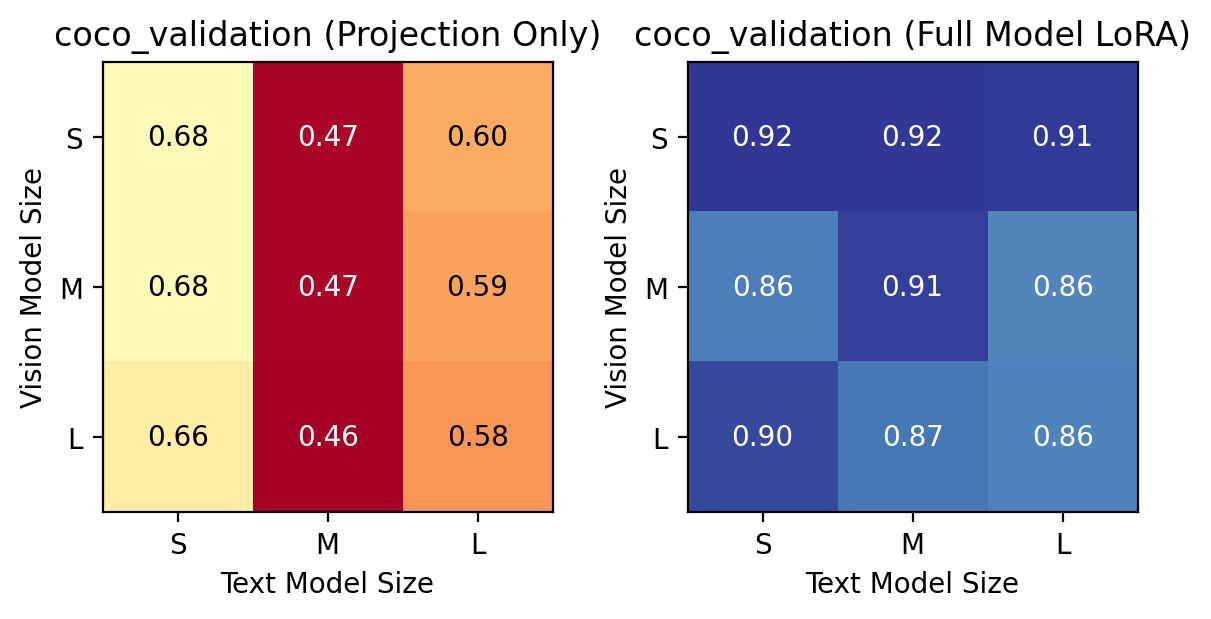

In [6]:
plot_side_by_side_heatmaps("coco_validation", text_saliency_threshold=0.2)

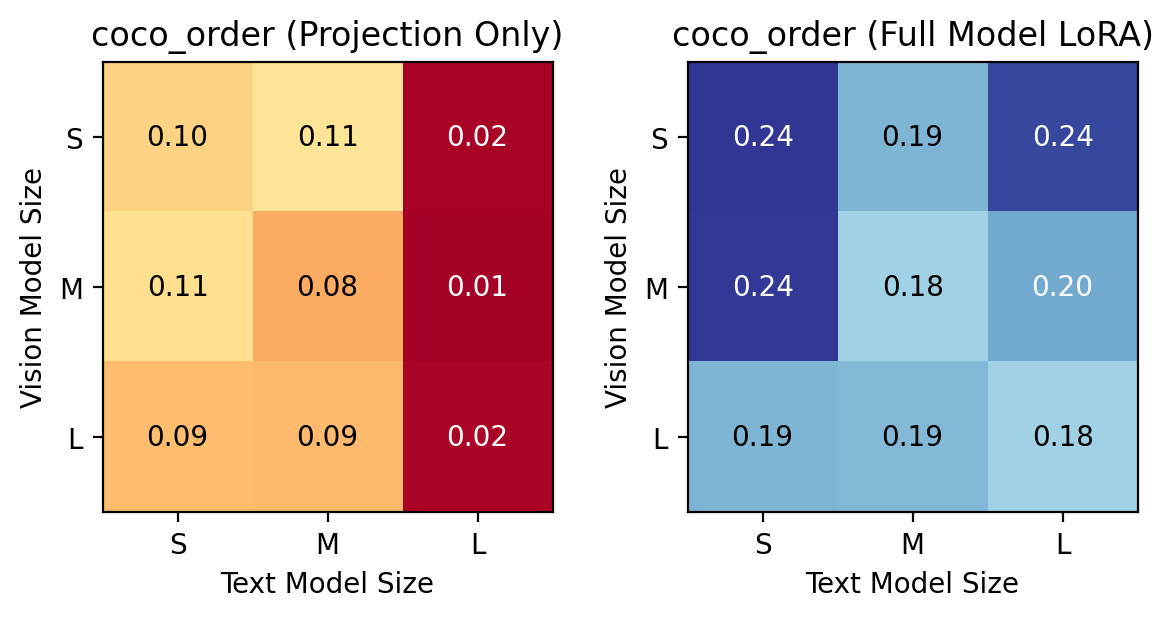

In [7]:
plot_side_by_side_heatmaps("coco_order", text_saliency_threshold=0.5)

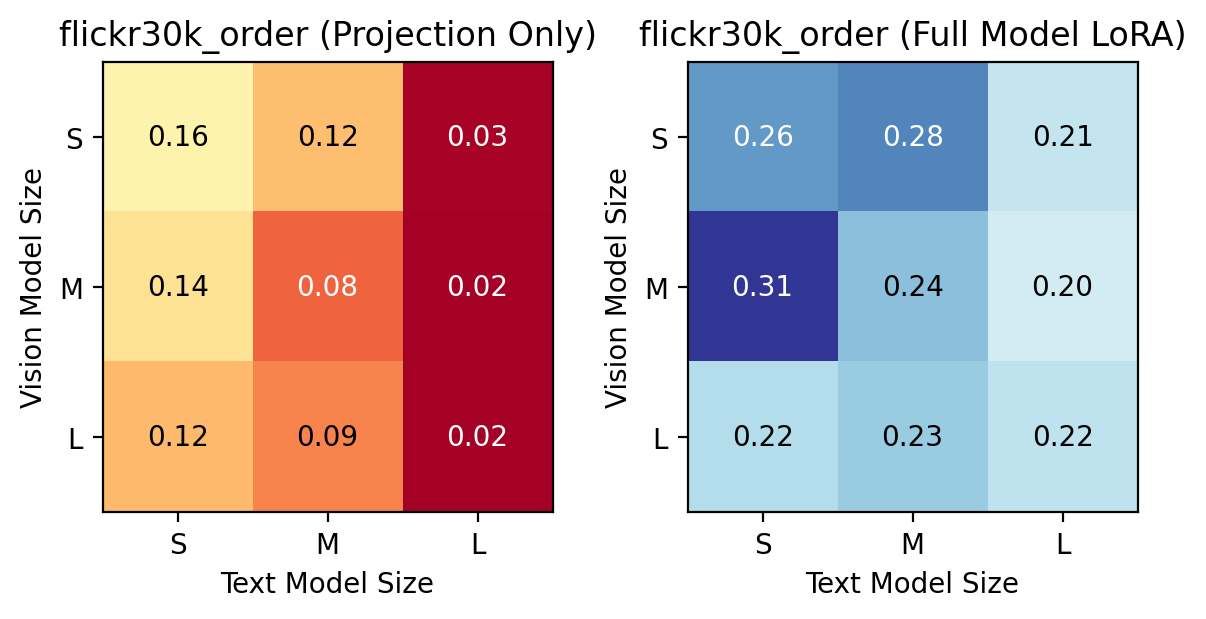

In [8]:
plot_side_by_side_heatmaps("flickr30k_order", text_saliency_threshold=0.5)

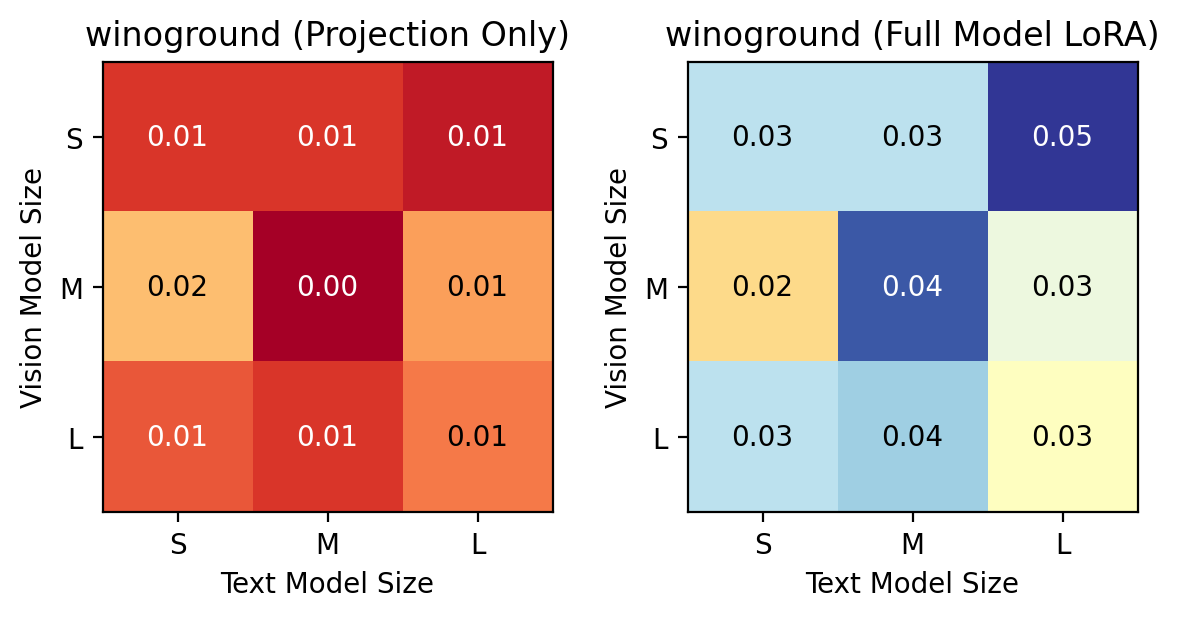

In [9]:
plot_side_by_side_heatmaps("winoground", text_saliency_threshold=0.5)

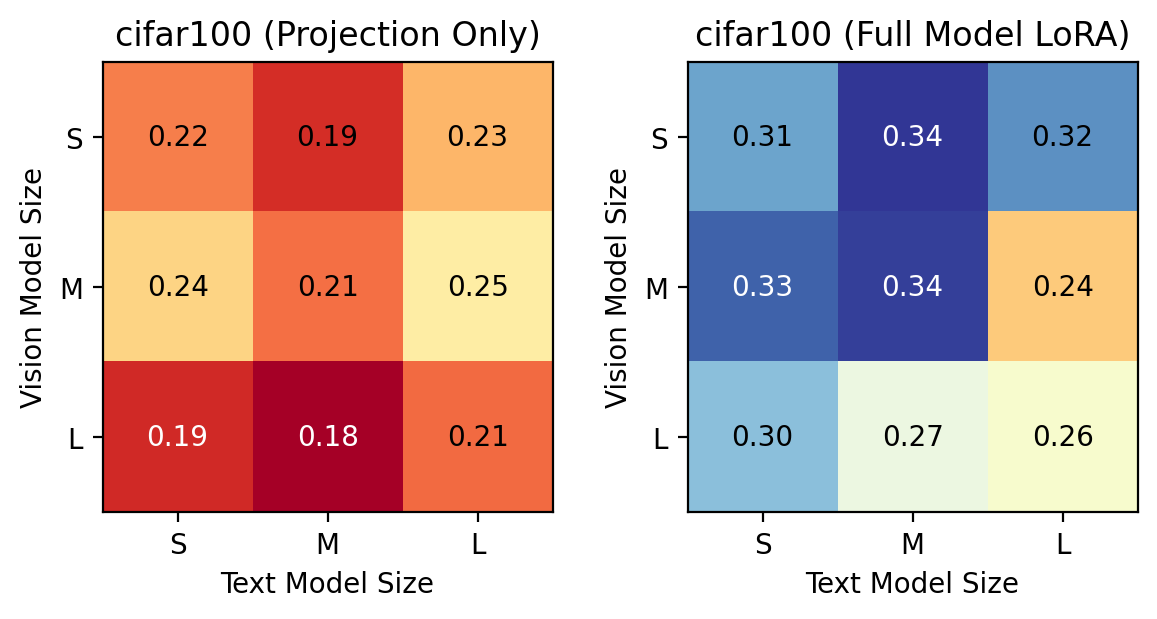

In [10]:
plot_side_by_side_heatmaps("cifar100")

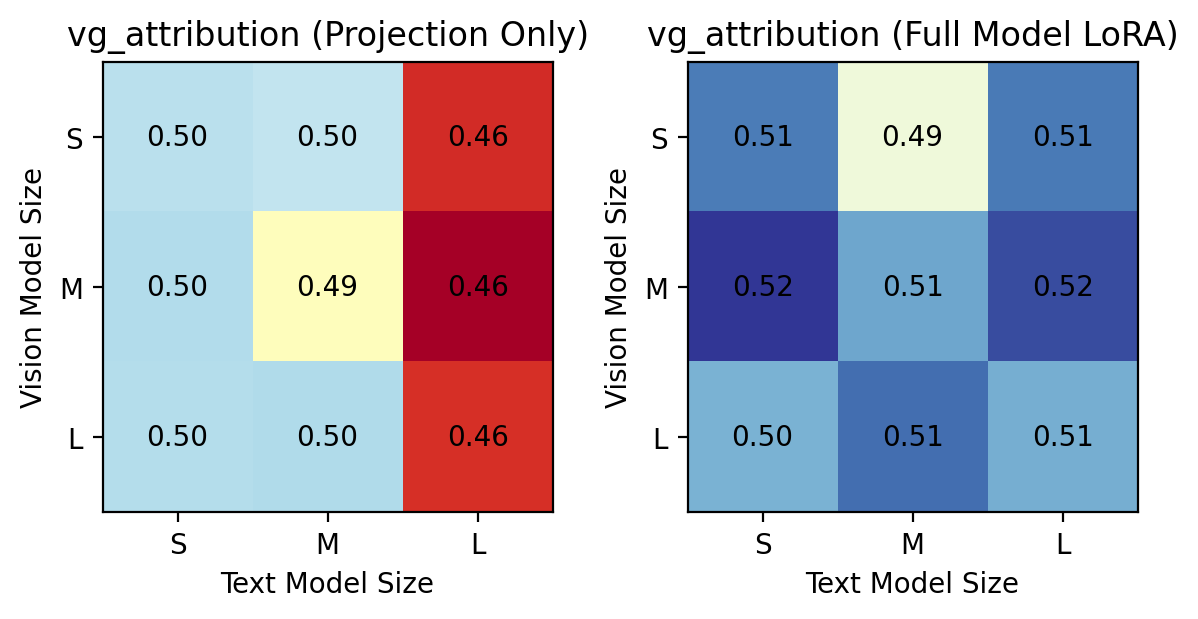

In [11]:
plot_side_by_side_heatmaps("vg_attribution", text_saliency_threshold=0.2)

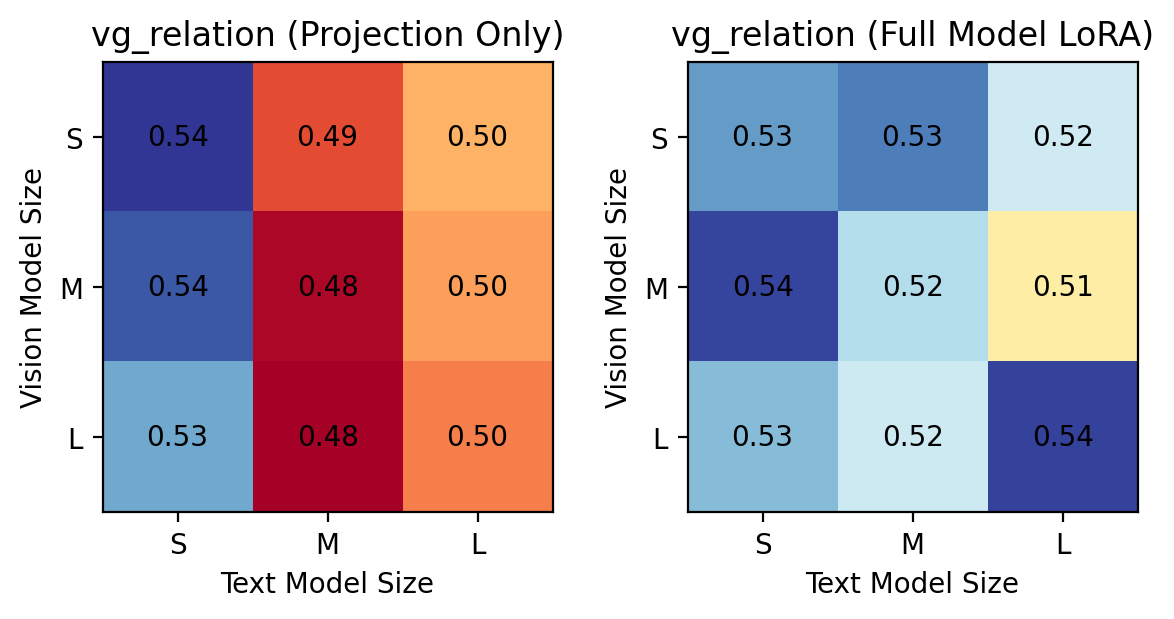

In [12]:
plot_side_by_side_heatmaps("vg_relation", text_saliency_threshold=0.2)

In [52]:
def plot_all_heatmaps(cmap='RdYlBu', text_saliency_threshold=0.25):
    sizes = ["small", "medium", "large"]
    size_labels = ["S", "M", "L"]

    benchmarks = ["vg_attribution", "vg_relation", "winoground", "flickr30k_order", "coco_order", "Overall Mean"]

    all_heatmaps = np.zeros((len(benchmarks)+1, len(sizes), len(sizes)))

    for i, vision_size in enumerate(sizes):
        for j, text_size in enumerate(sizes):
            for k in range(len(benchmarks)-1):
                all_heatmaps[k, i, j] = load_accuracy(text_size, vision_size, benchmarks[k], use_peft=True)
            
            # print(all_heatmaps[:len(benchmarks), i, j].mean())

            all_heatmaps[len(benchmarks)-1, i, j] = all_heatmaps[:len(benchmarks), i, j].mean()
            
    # all_heatmaps[-1, i, j] = 

    # vmin = all_heatmaps.min()
    # vmax = all_heatmaps.max()

    fig, axs = plt.subplots(2, 3, figsize=(9, 6), dpi=200)

    idx = 0

    for x in range(2):
        for y in range(3):

            vmin, vmax = all_heatmaps[idx].min(), all_heatmaps[idx].max()

            im2 = axs[x][y].imshow(all_heatmaps[idx], cmap=cmap, interpolation="nearest", vmin=vmin, vmax=vmax)
            axs[x][y].set_title(f"{benchmarks[idx]}")
            axs[x][y].set_xticks(range(len(size_labels)))
            axs[x][y].set_xticklabels(size_labels)
            axs[x][y].set_yticks(range(len(size_labels)))
            axs[x][y].set_yticklabels(size_labels)
            axs[x][y].set_xlabel("Text Model Size")
            axs[x][y].set_ylabel("Vision Model Size")
            for i in range(len(size_labels)):
                for j in range(len(size_labels)):
                    axs[x][y].text(j, i, f"{all_heatmaps[idx, i, j]:.2f}", ha="center", va="center", color="white" if abs(all_heatmaps[idx, i, j] - ((vmax + vmin) / 2)) > (((vmax + vmin) / 2) * text_saliency_threshold) else "black")

            idx += 1

    plt.tight_layout()
    # cbar = fig.colorbar(im1, ax=axs, location="right", shrink=0.8, label="Accuracy")
    plt.show()

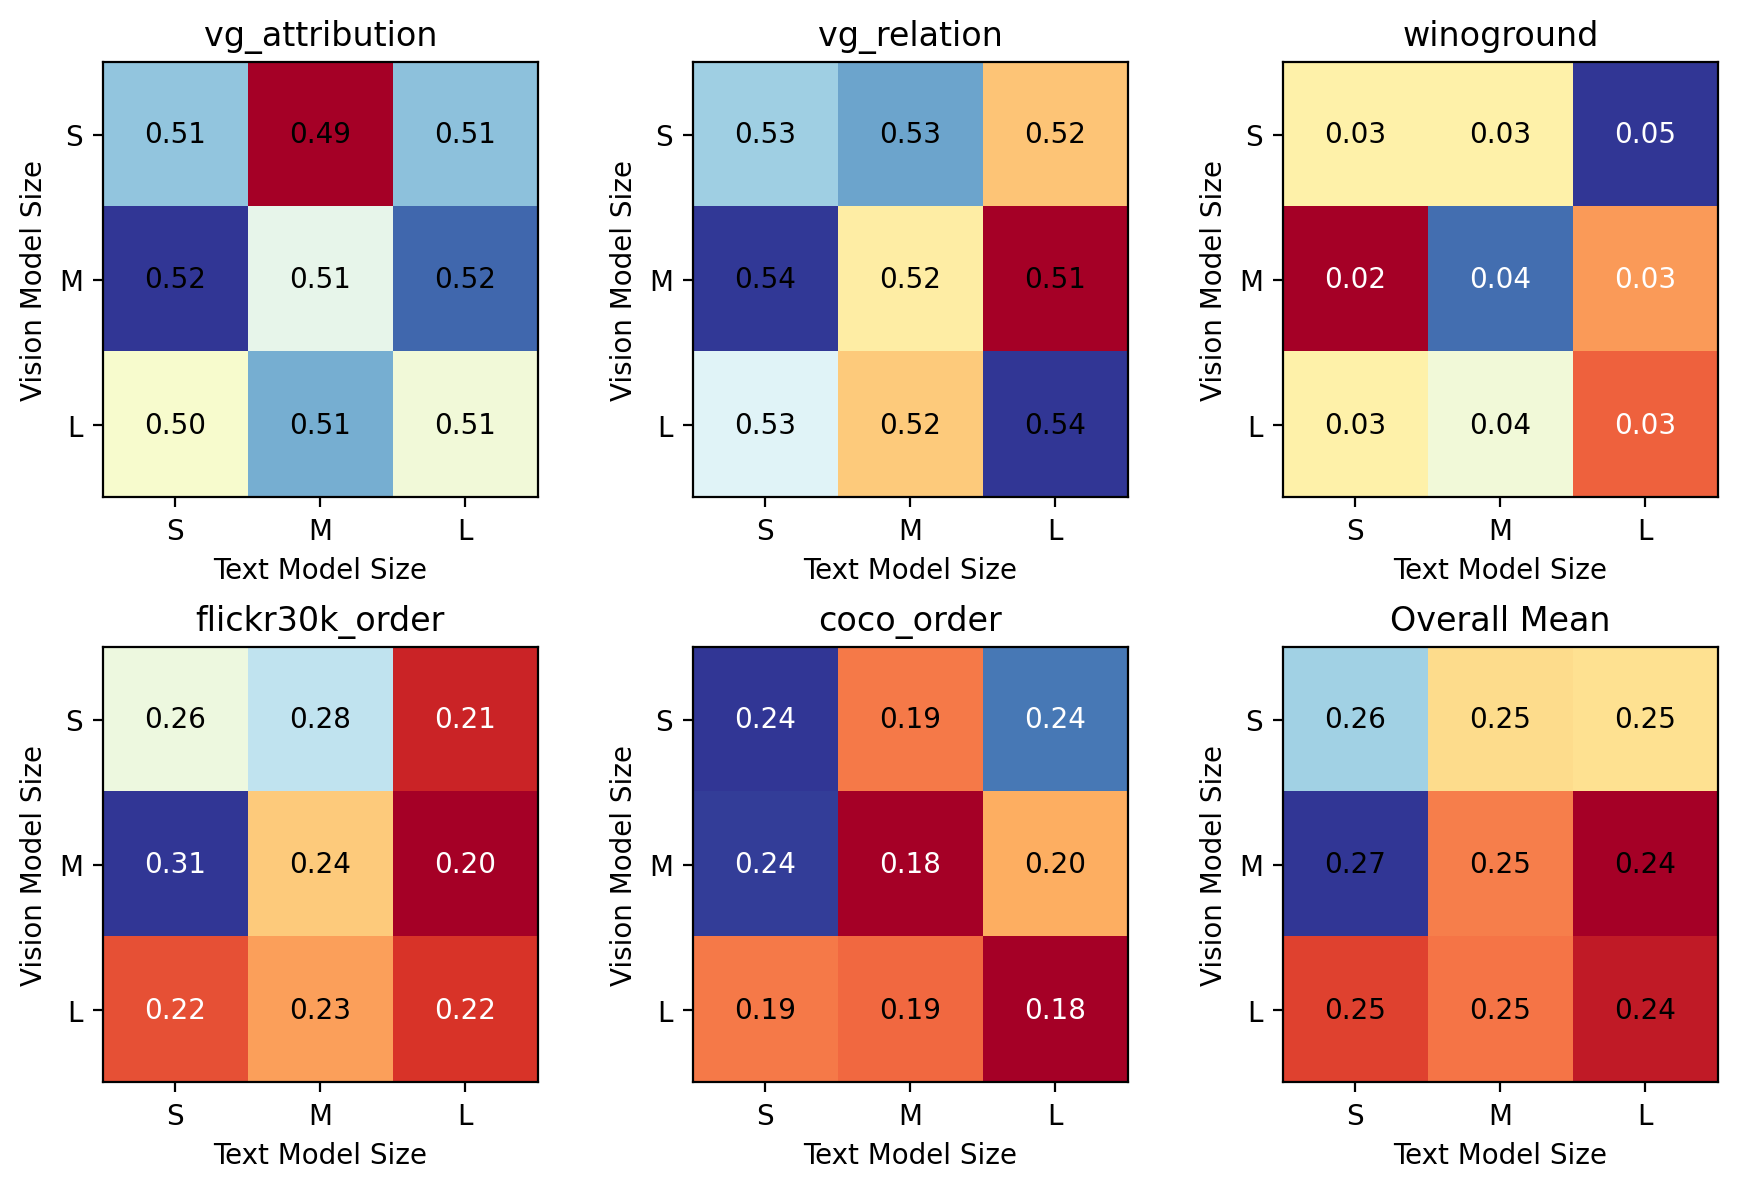

In [53]:
plot_all_heatmaps(text_saliency_threshold=0.1)